# Multi-Arm Bandits

A one-armed bandit is a slot machine that chooses a random number (positive meaning profit, negative meaning loss) from an internal probability distribution. This probability distribution is unknown to us, but by playing enough with the machine we can make estimates.

In the multi-arm case, we can choose between several one-armed bandit machines, that all have their own internal probability distributions.
If we play with all machines for a sufficient time, we can find out which machine is the most profitable for us (*exploration*), with some degree of confidence. Afterwards, we mostly play on that machine to try to maximize our profit (*exploitation*).

The difficulty is that we need to find a good trade-off between exploration and exploitation. If the probability distributions of the bandits can change (*nonstationary distributions*), this makes the problem difficult as we can never totally stop exploring.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

All one-armed bandits that are simulated here follow normal distributions.

In [3]:
from random import normalvariate

class ArmedBandit:
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance
        
    def sample(self):
        return normalvariate(self.mean, self.variance)

A bandit ensemble is just a collection of one-armed bandits (i.e. a *multi-armed bandit*).

In [78]:
import numpy as np
from random import random, randint

class BanditEnsemble:
    def __init__(self, num_bandits, Bandit=ArmedBandit):
        self.num_bandits = num_bandits
        self.bandits = []
        
        for i in range(num_bandits):
            mean = (random() - 0.5) * 3
            variance = 1
            bandit = Bandit(mean, variance)
            self.bandits.append(bandit)
            
    def sample(self, i):
        return self.bandits[i].sample()
    
    def __len__(self):
        return self.num_bandits
    
    def random_bandit(self):
        return randint(0, self.num_bandits - 1)

The `Game` class evaluates a collection of players in multiple games and plots their accumulated reward.

In [102]:
from time import time

class Game:
    def __init__(self, player_generators, Bandit=ArmedBandit):
        self.player_generators = player_generators
        self.Bandit = Bandit
        
    def play(self, num_bandits, num_games, num_iterations):
        t = time()
        
        num_players = len(self.player_generators)
        values = [[0] * num_iterations for _ in range(num_players)]
        
        for _ in range(num_games):
            bandits = BanditEnsemble(num_bandits=num_bandits, Bandit=self.Bandit)    
            players = [gen(bandits) for gen in self.player_generators]
            value = [0] * num_players

            for i in range(num_iterations):
                for j, player in enumerate(players):
                    reward = player.play(i)
                    val = value[j] + reward
                    values[j][i] += val
                    value[j] = val

        for j, player in enumerate(players):
            label = str(player)
            plt.plot(values[j], label=label)

        plt.legend(bbox_to_anchor=(.5, -.6), loc='lower center')
        plt.xlabel('time units')
        plt.ylabel('accumulated reward')
        plt.title("%d bandits, %d games, %d time units (generated in %.2fsec)" % (num_bandits, num_games, num_iterations, time() - t), y=1.08)
        plt.show()

## $\epsilon$-Greedy Strategy


The `EpsilonGreedyPlayer` chooses the bandit that we currently consider to be the best with a probability of $1 - \epsilon$, and a random bandit otherwise. Ties are broken using a random choice.

The expected reward of a bandit (i.e. the mean of the given rewards so far) is calculated using:

$$ Q_{n + 1} = Q_n + \frac1n * (R - Q_n)$$

where $Q_n$ is the mean reward after $n - 1$ steps and $R$ is the reward in step $n$.

In [109]:
class EpsilonGreedyPlayer:
    def __init__(self, bandits, epsilon, initial=0):
        self.bandits = bandits
        self.epsilon = epsilon
        self.initial = initial
        
        n = len(bandits)
        self.expected = [initial] * n
        self.num_played = [0] * n
        
    def play(self, t):
        bandit_i = self._select_bandit(t)
            
        reward = self.bandits.sample(bandit_i)
        self.num_played[bandit_i] += 1
        
        self._adapt_expected_reward(bandit_i, reward)
                    
        return reward
    
    def _select_bandit(self, t):
        if random() > self.epsilon:
            return np.argmax(self.expected)
        else:
            return self.bandits.random_bandit()
    
    def _adapt_expected_reward(self, bandit_i, reward):
        alpha = self._get_alpha(bandit_i)
        expected_reward = self.expected[bandit_i]
        self.expected[bandit_i] = expected_reward + alpha * (reward - expected_reward)
    
    def _get_alpha(self, bandit_i):
        return 1. / self.num_played[bandit_i]
    
    def __str__(self):
        return "greedy(epsilon=%.3f, initial=%d)" % (self.epsilon, self.initial)

In the case of $\epsilon = 0$ we always play the first bandit that gave us a positive reward. In the case of $\epsilon = 1$ we always play a random bandit. Of course $\epsilon = 0.1$ is superior to both.

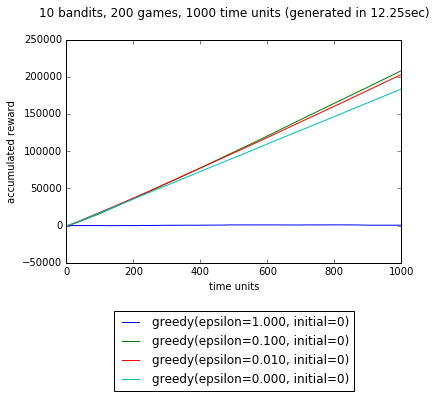

In [104]:
players = [
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=1),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.1),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.01),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0)
]

game = Game(players)
game.play(num_bandits=10, num_games=200, num_iterations=1000)

## Optimistic Initial Values

In this stationary distribution case, $\epsilon$ is not really necessary if we take some time to explore all bandits in the beginning. This can be done by setting the initial expected reward for each bandit to a high positive value (like $20$). This makes us explore all bandits until the expected rewards adapt more to their true values.

As we can see this works very well here.

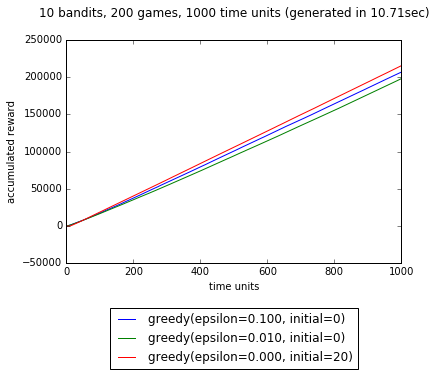

In [92]:
players = [
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.1),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.01),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0, initial=20)
]

game = Game(players)
game.play(num_bandits=10, num_games=200, num_iterations=1000)

## Upper-Confidence-Bound Action Selection

In [138]:
from math import sqrt, log

class UpperConfidenceBoundPlayer(EpsilonGreedyPlayer):
    def __init__(self, bandits, c, initial=0):
        EpsilonGreedyPlayer.__init__(self, bandits, epsilon=0, initial=initial)
        self.c = c
        
    def _select_bandit(self, t):
        expected = [reward + self.c * sqrt(log(t + 1) / (n + 1e-10)) for reward, n in zip(self.expected, self.num_played)]
        
        return np.argmax(expected)
    
    def __str__(self):
        return "ucb(c=%.3f, initial=%d)" % (self.c, self.initial)

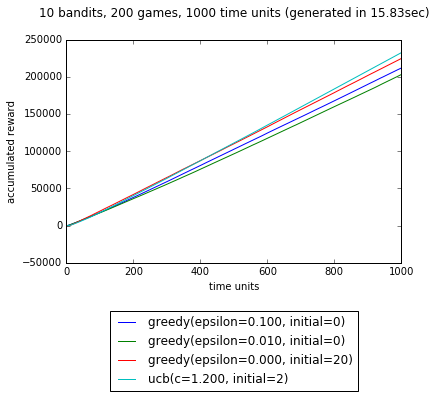

In [140]:
players = [
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.1),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.01),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0, initial=20),
    lambda bandits: UpperConfidenceBoundPlayer(bandits, c=1.2, initial=2)
]

game = Game(players)
game.play(num_bandits=10, num_games=200, num_iterations=1000)

## Nonstationary Distributions

There's now a small chance that the slot machine changes its probability distribution. This makes it important to keep exploring during the entire game.

In [87]:
from random import random, normalvariate

class UnreliableArmedBandit:
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance
        
    def sample(self):
        if random() > 0.85:
            self.mean = (random() - 0.5) * 3
            self.variance = 1
            
        return normalvariate(self.mean, self.variance)

Our earlier $\epsilon$-approaches all fail because they do not expect the distribution to change. If the distribution changes, the stored means do not represent the expected reward anymore.

The `UpperConfidenceBoundPlayer` still performs well because it keeps exploring other promising options.

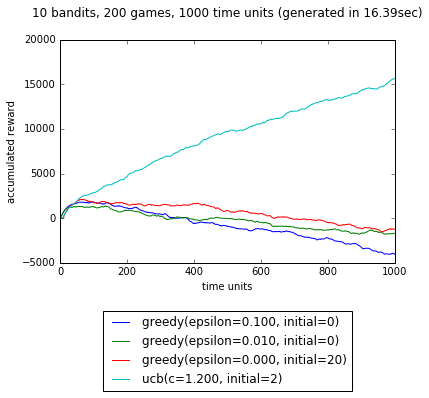

In [141]:
players = [
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.1),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.01),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0, initial=20),
    lambda bandits: UpperConfidenceBoundPlayer(bandits, c=1.2, initial=2)
]

game = Game(players, Bandit=UnreliableArmedBandit)
game.play(num_bandits=10, num_games=200, num_iterations=1000)

We can easily improve the $\epsilon$-greedy algorithms by calculating a weighted average where recent rewards are highly weighted. This can be done by changing $\frac1n$ in the update rule to a constant value $\alpha$, thus creating an [exponentially moving average](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average).

In [117]:
class NonstationaryEpsilonGreedyPlayer(EpsilonGreedyPlayer):
    def __init__(self, bandits, epsilon, alpha, initial=0):
        EpsilonGreedyPlayer.__init__(self, bandits, epsilon, initial)
        self.alpha = alpha
        
    def _get_alpha(self, bandit_i):
        return self.alpha
    
    def __str__(self):
        return "greedy(epsilon=%.3f, alpha=%.3f, initial=%d)" % (self.epsilon, self.alpha, self.initial)

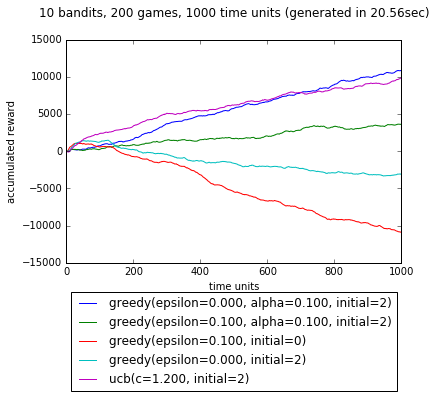

In [142]:
players = [
    lambda bandits: NonstationaryEpsilonGreedyPlayer(bandits, epsilon=0, alpha=0.1, initial=2),
    lambda bandits: NonstationaryEpsilonGreedyPlayer(bandits, epsilon=0.1, alpha=0.1, initial=2),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.1),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0, initial=2),
    lambda bandits: UpperConfidenceBoundPlayer(bandits, c=1.2, initial=2)
]

game = Game(players, Bandit=UnreliableArmedBandit)
game.play(num_bandits=10, num_games=200, num_iterations=1000)

## Gradient Optimization

This gradient based player chooses bandits to play from a softmax distribution. The values for that distribution are adapted using an algorithm that's similar to stochastic gradient descent.

In [197]:
from numpy import exp
from random import random

class GradientSoftMaxPlayer(EpsilonGreedyPlayer):
    def __init__(self, bandits, alpha):
        self.bandits = bandits
        self.alpha = alpha
        
        self.preferences = [0] * len(bandits)
        
        EpsilonGreedyPlayer.__init__(self, bandits, epsilon=0)
        
    def _select_bandit(self, t):
        while True:
            for i in range(len(self.bandits)):
                prob = self._get_prob(i)
                if prob > random():
                    return i
    
    def _adapt_expected_reward(self, bandit_i, reward):
        for i in range(len(self.bandits)):
            prob = self._get_prob(i)
            baseline = self.expected[bandit_i]
            
            if i == bandit_i:
                multiplier = 1 - prob
            else:
                multiplier = -prob
            
            self.preferences[i] += self.alpha * (reward - baseline) * multiplier
    
    def _get_prob(self, bandit_i):
        max_pref = max(self.preferences)
        x = self.preferences[bandit_i] - max_pref
        xs = [pref - max_pref for pref in self.preferences]
        
        return exp(x) / sum(np.exp(xs))
        
    def __str__(self):
        return "gradient(alpha=%.3f)" % self.alpha

Here, the `GradientSoftMaxPlayer` doesn't outperform a simple `EpsilonGreedyPlayer`.

In the nonstionary case it performs pretty badly, because the mean reward is not exponentially weighted.

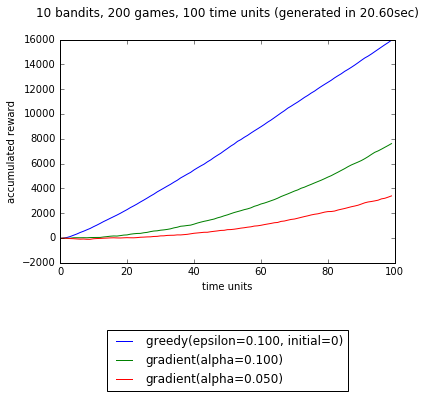

In [198]:
players = [
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.1),
    lambda bandits: GradientSoftMaxPlayer(bandits, alpha=0.1),
    lambda bandits: GradientSoftMaxPlayer(bandits, alpha=0.05),
]

game = Game(players)
game.play(num_bandits=10, num_games=200, num_iterations=100)